In [63]:
%pip install numpy pandas seaborn matplotlib 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 24  # Number of steps for payload sizes
run_time_seconds = 30  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

num_users_list = np.array([64])
payload_sizes = np.unique(np.logspace(0, 20, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

In [65]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


    num_users  spawn_rate  payload_size        csv_filename
0          64          64             1        results_1_64
1          64          64             3        results_3_64
2          64          64             6        results_6_64
3          64          64            11       results_11_64
4          64          64            20       results_20_64
5          64          64            37       results_37_64
6          64          64            67       results_67_64
7          64          64           124      results_124_64
8          64          64           226      results_226_64
9          64          64           414      results_414_64
10         64          64           757      results_757_64
11         64          64          1384     results_1384_64
12         64          64          2528     results_2528_64
13         64          64          4620     results_4620_64
14         64          64          8442     results_8442_64
15         64          64         15425 

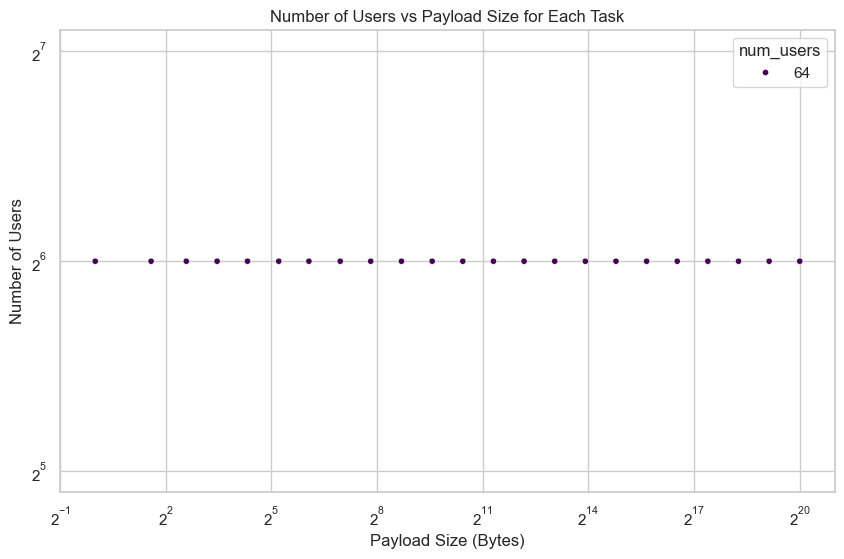

In [66]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [67]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [68]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://192.168.1.105:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(num_workers)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

payload_size: 1
payload_size: 1
payload_size: 1
payload_size: 1
payload_size: 1


[2023-11-13 08:06:13,485] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:06:13,493] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_786253425f2346ae99faf424eb037fd3 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:06:13,495] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 3payload_size: 3

payload_size: 3payload_size: 3

payload_size: 3


[2023-11-13 08:06:46,633] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:06:46,637] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_85120555a90848b18fe4da64424bcad5 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:06:46,637] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6


[2023-11-13 08:07:19,857] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:07:19,860] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_0a7b700463e54944bdae654aeaaf4e5d (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:07:19,860] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11


[2023-11-13 08:07:53,012] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-13 08:07:53,013] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_3bfc1e921b574343b7f445651590ef33 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:07:53,015] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20


[2023-11-13 08:08:26,154] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-13 08:08:26,155] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_bd7c7d442bda4598b578cb964bf719c2 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:08:26,157] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37


[2023-11-13 08:08:59,294] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:08:59,298] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_ee0f44da41364a1e90cd9960b7d00037 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:08:59,298] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67


[2023-11-13 08:09:32,455] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:09:32,458] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_566d42ca558c413db36042c99b4f20da (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:09:32,458] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124


[2023-11-13 08:10:05,610] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:10:05,613] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_155575ee0cea44578675a0f95a23a995 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:10:05,613] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226


[2023-11-13 08:10:38,748] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:10:38,751] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_7d5ca28aea274e8d828ec5025de4eedb (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:10:38,752] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414


[2023-11-13 08:11:11,933] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:11:11,936] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_519aad2fb49f4448af7e22403c3f6b8d (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:11:11,938] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757


[2023-11-13 08:11:45,088] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:11:45,091] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_09ecf75cd26c427b8384c68c548fd53d (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:11:45,092] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1384
payload_size: 1384
payload_size: 1384
payload_size: 1384
payload_size: 1384


[2023-11-13 08:12:18,263] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-13 08:12:18,265] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_064ba3dfa9d2432f8d9fc7678ac0d820 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:12:18,267] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528


[2023-11-13 08:12:51,440] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-13 08:12:51,442] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_757ce4d32ff644f9b14a3a6a4c9e6079 (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:12:51,443] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620


[2023-11-13 08:13:24,616] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:13:24,619] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_3db8090b23914c29ade3b36cbf8e978a (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:13:24,620] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 8442
payload_size: 8442
payload_size: 8442
payload_size: 8442
payload_size: 8442


[2023-11-13 08:13:57,762] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:13:57,768] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_4709786e632b4a1ca4b93671270c8254 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:13:57,769] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 15425
payload_size: 15425
payload_size: 15425
payload_size: 15425
payload_size: 15425


[2023-11-13 08:14:30,932] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:14:30,938] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_19a2bd7a8264466c9a79568ce814dc92 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:14:30,939] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184


[2023-11-13 08:15:04,093] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-13 08:15:04,095] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_ae57eb94695242d8ad04b0dadc3c7fab (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:15:04,096] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 51496payload_size: 51496

payload_size: 51496
payload_size: 51496
payload_size: 51496


[2023-11-13 08:15:37,264] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:15:37,267] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_dbcc09b0452b48229555718c382b063b (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:15:37,267] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089


[2023-11-13 08:16:10,445] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:16:10,448] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_a461a4abf7c14df18c319ac76864ffe6 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:16:10,449] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911
payload_size: 171911


[2023-11-13 08:16:43,661] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:16:43,664] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_982f5cae828f4a92a7f83fbbb40af626 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:16:43,664] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 314101
payload_size: 314101
payload_size: 314101
payload_size: 314101
payload_size: 314101


[2023-11-13 08:17:16,811] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:17:16,814] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_c7cafdc060334c2f9ca4a5a81ffa3192 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:17:16,814] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897


[2023-11-13 08:17:49,969] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-13 08:17:49,972] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_c8ca13828ef34ba087fd421bf0c25b19 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:17:49,973] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576


[2023-11-13 08:18:23,126] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-13 08:18:23,128] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_7404cb3c687f4a2db569c62d119b3140 (index 0) reported as ready. 1 workers connected.
[2023-11-13 08:18:23,129] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_b204351ef1184585bd5c7aeb239432b7 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

In [69]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                    "med_response_time": float(agg_row["Median Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time  \
0              1         64           14270         132.328199   
1              3         64           14283         129.079156   
2              6         64           14284         129.759838   
3             11         64           14307         125.750464   
4             20         64           14301         125.522890   
5             37         64           14279         128.177275   
6             67         64           14258         129.595988   
7            124         64           14303         127.450096   
8            226         64           14257         120.988389   
9            414         64           14220         131.858704   
10           757         64           14261         124.360401   
11          1384         64           14153         128.775165   
12          2528         64           14080         131.673970   
13          4620         64           14000         134.710949   
14        

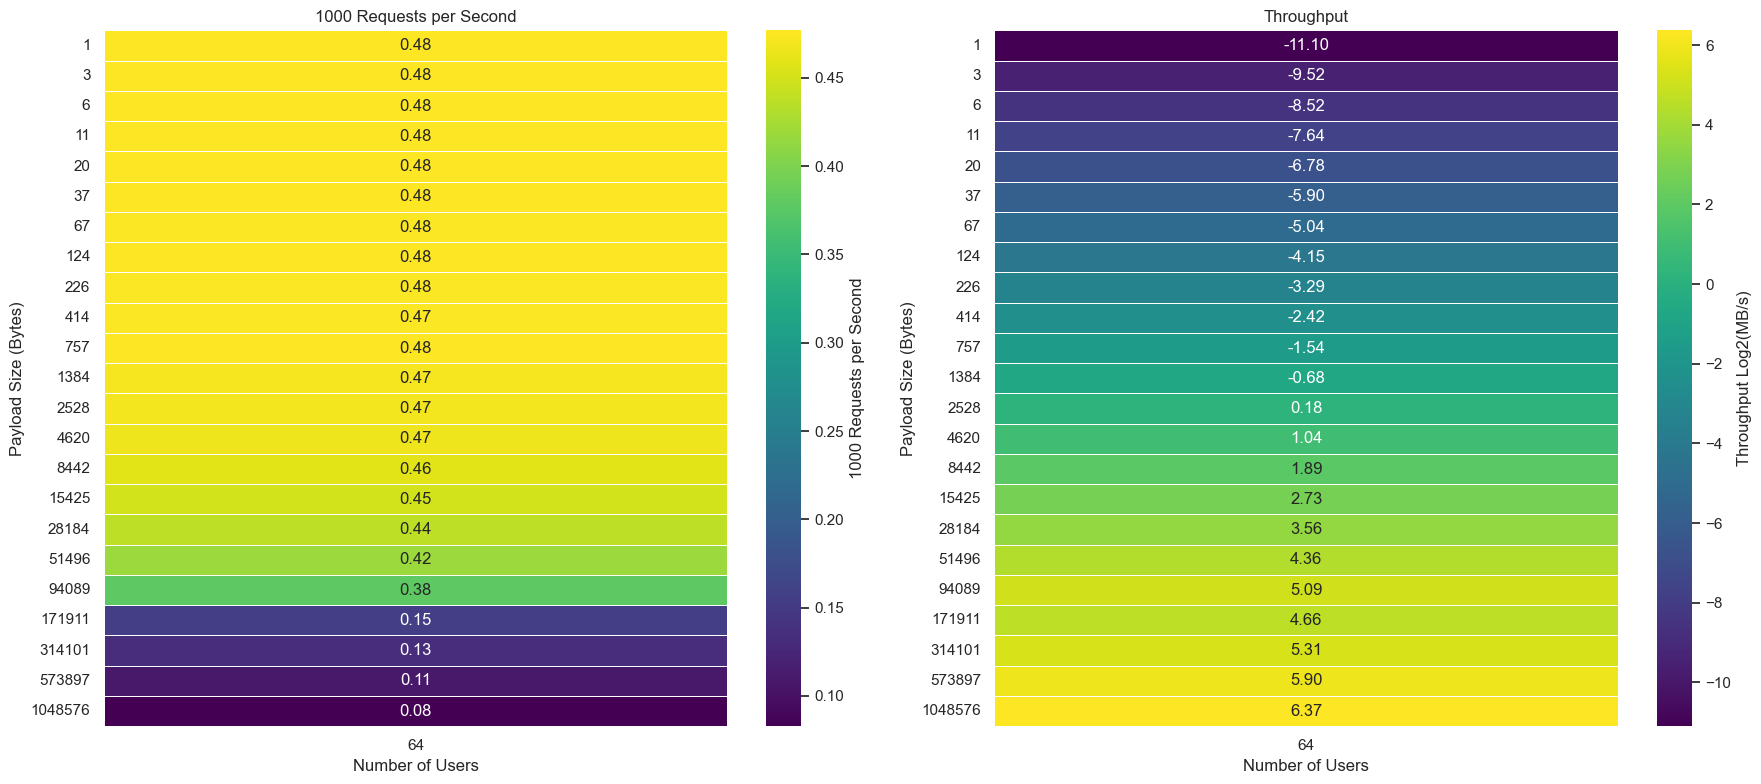

In [70]:
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

#results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']
results_df['med_response_time_per_user'] = results_df['med_response_time'] / results_df['num_users']
results_df['throughput'] = results_df['total_requests'] / run_time_seconds * results_df['payload_size'] / 1024 / 1024 # MB/s

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="requests_per_second")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="throughput")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rps, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "1000 Requests per Second"}, ax=axes[0])
axes[0].set_title('1000 Requests per Second')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
log_heatmap_data = np.log2(heatmap_data_rt + 1e-6)
sns.heatmap(log_heatmap_data, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Throughput Log2(MB/s)"}, ax=axes[1])
axes[1].set_title('Throughput')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()


In [71]:
print( results_df['num_users'])

0     64
1     64
2     64
3     64
4     64
5     64
6     64
7     64
8     64
9     64
10    64
11    64
12    64
13    64
14    64
15    64
16    64
17    64
18    64
19    64
20    64
21    64
22    64
Name: num_users, dtype: int64


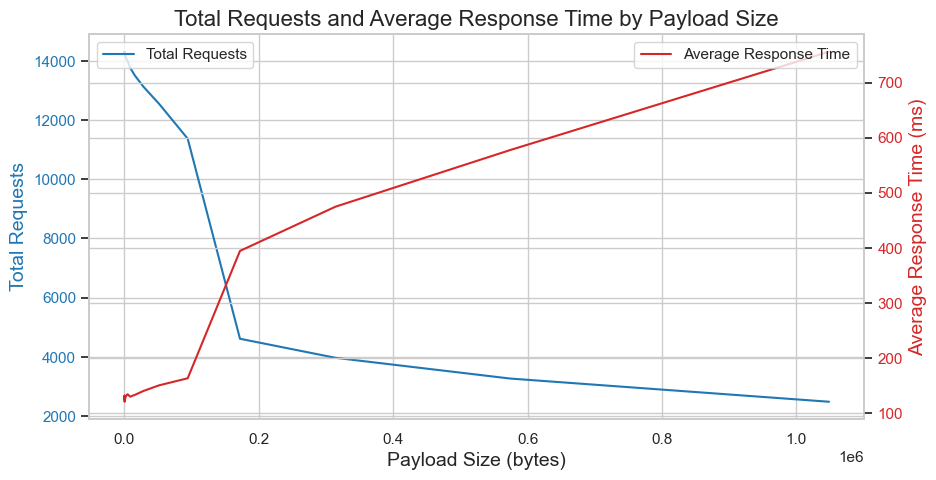

In [72]:
# Assuming 'results_df' is your DataFrame

# First, we will group the data by 'payload_size' and calculate the mean 'total_requests' and 'avg_response_time'.
# This is necessary because your data seems to have multiple entries for each 'payload_size'.
grouped = results_df.groupby('payload_size').mean().reset_index()

# Now let's plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set the x-axis label
ax1.set_xlabel('Payload Size (bytes)', fontsize=14)

# Plot the 'total_requests' on the left y-axis
ax1.set_ylabel('Total Requests', color='tab:blue', fontsize=14)
ax1.plot(grouped['payload_size'], grouped['total_requests'], color='tab:blue', label='Total Requests')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Response Time (ms)', color='tab:red', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(grouped['payload_size'], grouped['avg_response_time'], color='tab:red', label='Average Response Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title of the plot
plt.title('Total Requests and Average Response Time by Payload Size', fontsize=16)

# Show a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()